<a href="https://colab.research.google.com/github/Annie-Yeeun-Jang/Plant_disease_classification/blob/master/DenseNet_no_freeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import necessary packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, Activation, Dropout, Dense
from keras.optimizers import Adam
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
dst_path = '/content/gdrive/My Drive/dataset_split_aug'
# 경로 지정
import os
os.chdir('/content/gdrive/My Drive/dataset_split_aug')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### 이미지 노이즈

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(dst_path, 'train')
validation_dir = os.path.join(dst_path, 'validation')
test_dir = os.path.join(dst_path, 'test')

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(64,64),
                                                    batch_size=64,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(64,64),
                                                        batch_size=64,
                                                        class_mode='categorical')

Found 30748 images belonging to 33 classes.
Found 7989 images belonging to 33 classes.


### DenseNet 모델 구성

In [ ]:
SIZE=64
N_ch=3

In [ ]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)

    for layer in densenet.layers:
      print(layer, layer.trainable)
      
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(33,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    #model.summary()
    return model

### 모델 실행

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)

MODEL_SAVE_FOLDER_PATH='/content/gdrive/My Drive/model_save/dense_no/'
model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

checkpoint= ModelCheckpoint(filepath=model_path,monitor='val_accuracy',verbose=1, save_best_only=True)
earlystop=EarlyStopping(patience=10)

my_callbacks = [earlystop,checkpoint,annealer]

In [ ]:
model = build_densenet()
model.summary()

29089792/29084464 [==============================] - 2s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7fb1dbd1c8d0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fb1dbdcd400> True
<keras.layers.convolutional.Conv2D object at 0x7fb1f123c898> True
<keras.layers.normalization.BatchNormalization object at 0x7fb187f86390> True
<keras.layers.core.Activation object at 0x7fb187f86f98> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7fb187f86e80> True
<keras.layers.pooling.MaxPooling2D object at 0x7fb187f86c50> True
<keras.layers.normalization.BatchNormalization object at 0x7fb187f86a90> True
<keras.layers.core.Activation object at 0x7fb1700ba278> True
<keras.layers.convolutional.Conv2D object at 0x7fb1700d9cc0> True
<keras.layers.normalization.BatchNormalization object at 0x7fb17009bdd8> True
<keras.layers.core.Activation object at 0x7fb1700a1e80> True
<keras.layers.convolutional.Conv2D object at 0x7fb170039ef0> True
<keras.layers.merge.Concatenate object 

In [ ]:
dense = model.fit_generator(train_generator,
                               epochs=50,
                               validation_data=validation_generator,
                               callbacks=my_callbacks)

Epoch 1/50
481/481 [==============================] - 121s 252ms/step - loss: 0.0601 - accuracy: 0.9823 - val_loss: 0.6432 - val_accuracy: 0.9091

Epoch 00001: val_accuracy improved from -inf to 0.90913, saving model to /content/gdrive/My Drive/model_save/dense_no/01-0.6432.hdf5
Epoch 2/50
481/481 [==============================] - 118s 245ms/step - loss: 0.0512 - accuracy: 0.9849 - val_loss: 0.2265 - val_accuracy: 0.9693

Epoch 00002: val_accuracy improved from 0.90913 to 0.96933, saving model to /content/gdrive/My Drive/model_save/dense_no/02-0.2265.hdf5
Epoch 3/50
481/481 [==============================] - 123s 255ms/step - loss: 0.0480 - accuracy: 0.9854 - val_loss: 0.0197 - val_accuracy: 0.9587

Epoch 00003: val_accuracy did not improve from 0.96933
Epoch 4/50
481/481 [==============================] - 119s 247ms/step - loss: 0.0481 - accuracy: 0.9846 - val_loss: 0.2157 - val_accuracy: 0.9558

Epoch 00004: val_accuracy did not improve from 0.96933
Epoch 5/50
481/481 [=============

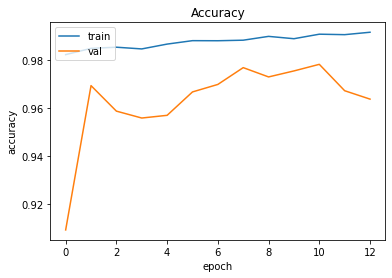

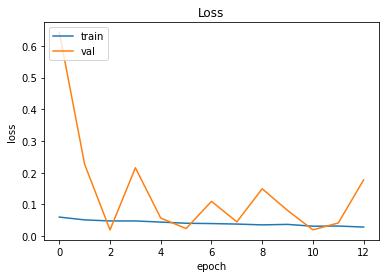

In [ ]:
# accuracy plot 
plt.plot(dense.history['accuracy'])
plt.plot(dense.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# loss plot
plt.plot(dense.history['loss'])
plt.plot(dense.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('/content/gdrive/My Drive/model_save/dense_no/DenseNet_no.h5')

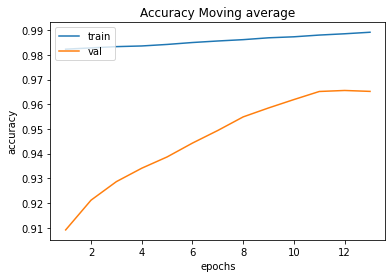

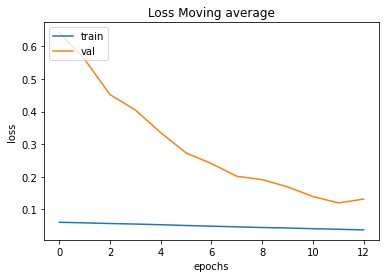

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history_train = smooth_curve(dense.history['accuracy'])
smooth_mae_history_val = smooth_curve(dense.history['val_accuracy'])
plt.plot(range(1, len(smooth_mae_history_train) + 1), smooth_mae_history_train)
plt.plot(range(1, len(smooth_mae_history_val) + 1), smooth_mae_history_val)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy Moving average')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(smooth_curve(dense.history['loss']))
plt.plot(smooth_curve(dense.history['val_loss']))
plt.title('Loss Moving average')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()